In [3]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [8]:
# Functions
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

In [11]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [14]:
env = BlackjackEnv()

In [15]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    useable_ace = [False, True]
    # Create dictionaries of states
    for sum in range(12,22):
        for dealer_score in range(1, 11):
            for i in range(len(useable_ace)):
                returns_sum[(sum, dealer_score, useable_ace[i])] = 0
                returns_count[(sum, dealer_score, useable_ace[i])] = 0
                V[(sum, dealer_score, useable_ace[i])] = 0
    
    # Implement this!
    for episode in range(num_episodes):
        observation = env.reset()
        states_visited = []
        total_return = 0
        
        for time_step in range(1,200): # 200 time-steps
            # Every-visit MC policy eval
            player_score = observation[0]
            dealer_score = observation[1]
            useable_ace = observation[2]
            
            returns_count[(player_score, dealer_score, useable_ace)] += 1
            states_visited.append((player_score, dealer_score, useable_ace))
            
            # Take Action
            #print_observation(observation)
            action = policy(observation)
            #print("Taking action: {}".format( ["Stick", "Hit"][action]))
            
            observation, reward, done, _ = env.step(action)
            total_return += discount_factor ** (time_step - 1) * reward
            
            if done:
                #print_observation(observation)
                #print("Game end. Reward: {}\n".format(float(reward)))
                break
            
        for state in set(states_visited):
            returns_sum[state] += total_return
    
    # Non-Incremental Value Function update
    for key, value in returns_sum.items():
        if returns_count[key] != 0:
            V[key] = value / returns_count[key]
    
    return V    

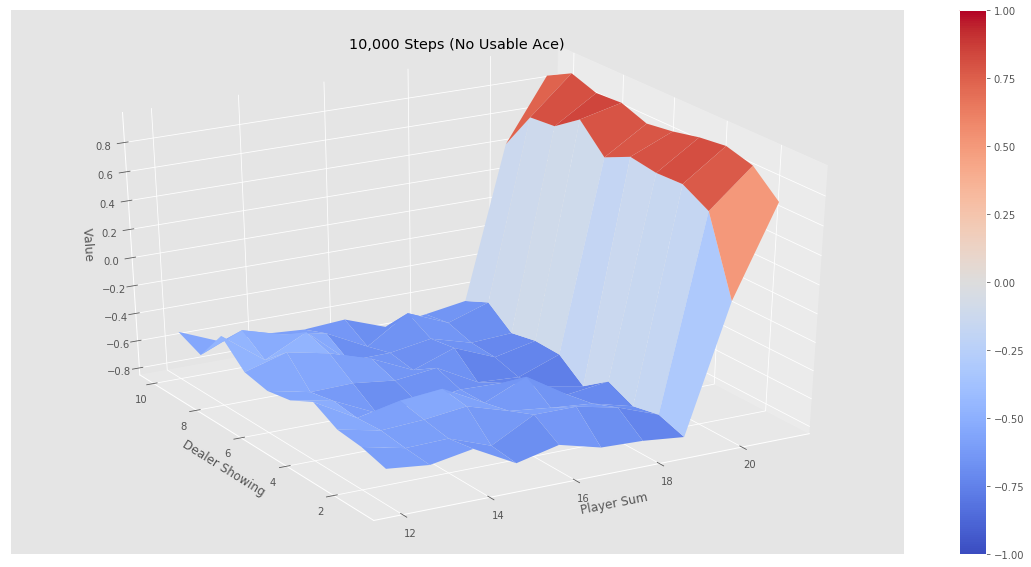

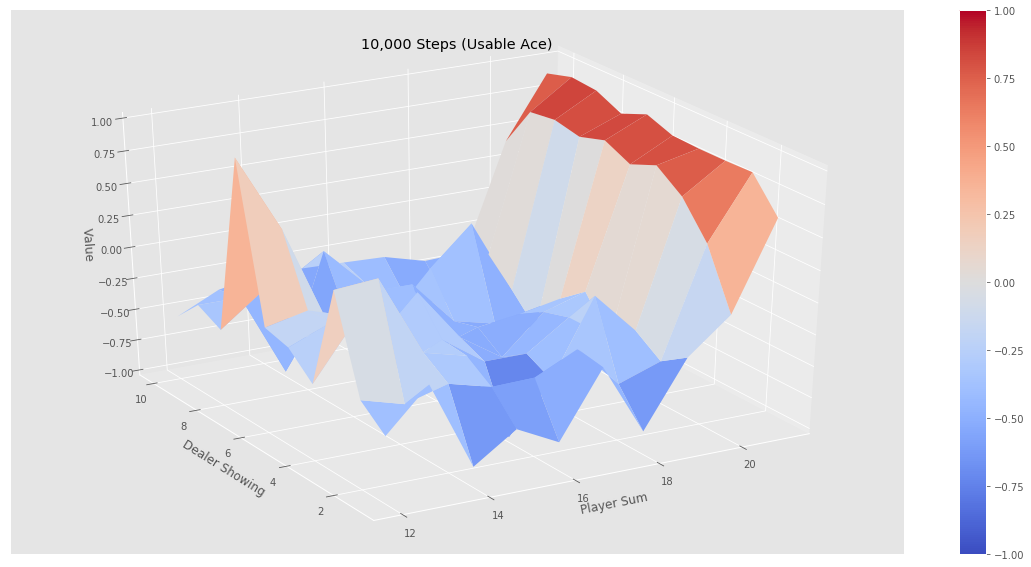

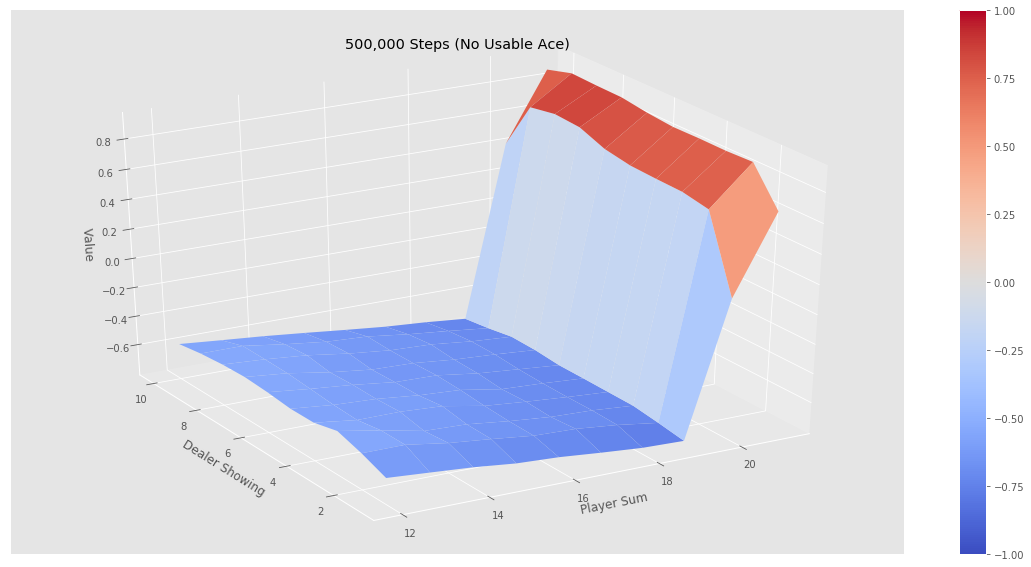

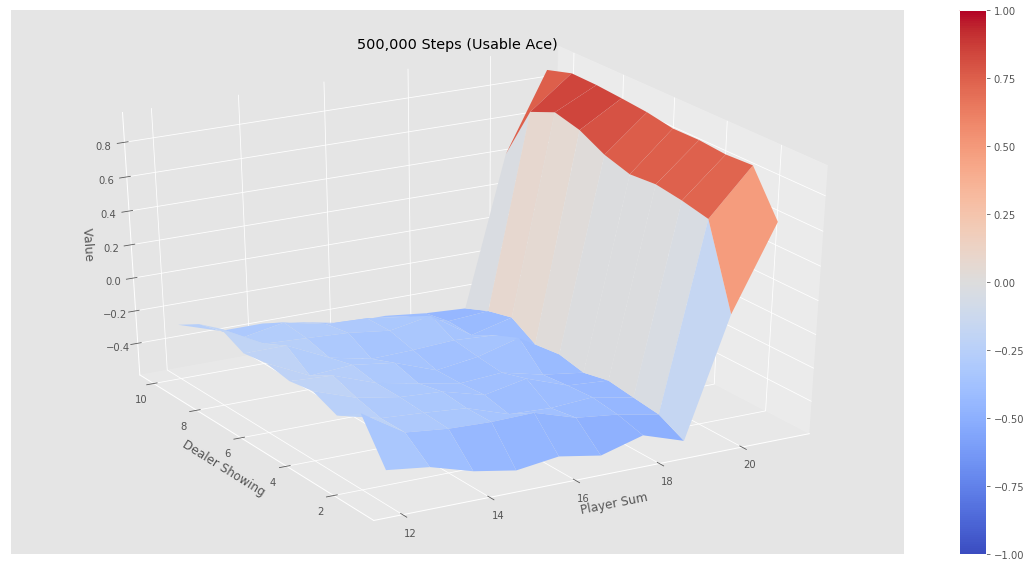

In [16]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")